In [4]:
import layoutparser as lp
import fitz
from PIL import Image
import numpy as np
import sys
import os

repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(repo_root, "src"))

from text import TextWord

In [ ]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [6]:
color_map = {
'Text': 'red',
'Title': 'blue',
'List': 'green',
'Table': 'purple',
'Figure': 'pink',
}

In [8]:
pdf_path = os.path.join(repo_root,"data/NAB/Berichte_NAB 10-025_Kurzarbeitsprogram Geothermiebohrung Schlattingen.PDF")
#pdf_path = "data/test/1062.pdf"
with fitz.Document(pdf_path) as doc:
    page = doc.load_page(13)
    pixmap = page.get_pixmap()
    image = Image.frombytes("RGB", [pixmap.width, pixmap.height], pixmap.samples)
    image.show()

In [26]:
layout = model.detect(image)

In [27]:
layout_predicted = model.detect(image)

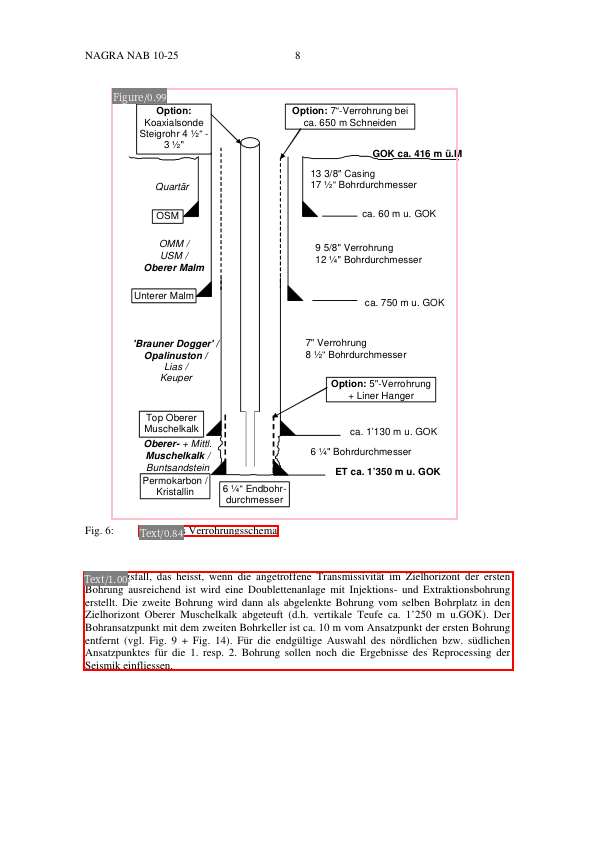

In [28]:
lp.draw_box(image, 
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              show_element_id=True, id_font_size=10, 
              color_map = color_map,
              id_text_background_color='grey',
              id_text_color='white')

In [29]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [30]:
# filter for text block
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

# sort text blocks

# convert image to  PIL image to numpy array
image_array = np.array(image)
h, w = image_array.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [32]:
## get text from document in bbox of layoutparser block
def get_intersecting_words(block,all_words): 
    intersecting_words=[]
    for word in all_words:
        if word.rect.intersects(block.coordinates):
            intersecting_words.append(word)
    return(intersecting_words)

with fitz.open(pdf_path) as doc:
    page=doc[13]
    words = []
    for x0, y0, x1, y1, word, block_no, line_no, _word_no in page.get_text("words"):
                rect = fitz.Rect(x0, y0, x1, y1) * page.rotation_matrix
                text_word = TextWord(rect=rect, text=word, page=13)
                words.append(text_word)
    
    for block in text_blocks._blocks:
        print(block.coordinates) 
        intersecting_words=get_intersecting_words(block=block,all_words=words)
        print(' '.join([word.text for word in intersecting_words]))

(139.8112335205078, 525.16357421875, 277.30877685546875, 536.8466796875)
Geplantes Verrohrungsschema
(84.08171081542969, 571.3047485351562, 512.4382934570312, 670.68310546875)
Im Erfolgsfall, das heisst, wenn die angetroffene Transmissivität im Zielhorizont der ersten Bohrung ausreichend ist wird eine Doublettenanlage mit Injektions- und Extraktionsbohrung erstellt. Die zweite Bohrung wird dann als abgelenkte Bohrung vom selben Bohrplatz in den Zielhorizont Oberer Muschelkalk abgeteuft (d.h. vertikale Teufe ca. 1’250 m u.GOK). Der Bohransatzpunkt mit dem zweiten Bohrkeller ist ca. 10 m vom Ansatzpunkt der ersten Bohrung entfernt (vgl. Fig. 9 + Fig. 14). Für die endgültige Auswahl des nördlichen bzw. südlichen Ansatzpunktes für die 1. resp. 2. Bohrung sollen noch die Ergebnisse des Reprocessing der Seismik einfliessen.


In [33]:
#text in figure block if exists
for block in figure_blocks._blocks:
        print(block.coordinates) 
        intersecting_words=get_intersecting_words(block=block,all_words=words)
        print(' '.join([word.text for word in intersecting_words]))

(112.56195831298828, 88.81603240966797, 456.89208984375, 519.9451904296875)
6 ¼“ Endbohr- durchmesser Option: Koaxialsonde Steigrohr 4 ½“ - 3 ½" ca. 60 m u. GOK ca. 750 m u. GOK 13 3/8" Casing 17 ½“ Bohrdurchmesser 9 5/8" Verrohrung 12 ¼" Bohrdurchmesser GOK ca. 416 m ü.M 7" Verrohrung 8 ½“ Bohrdurchmesser ca. 1’130 m u. GOK Unterer Malm Top Oberer Muschelkalk ET ca. 1’350 m u. GOK Option: 7“-Verrohrung bei ca. 650 m Schneiden Option: 5"-Verrohrung + Liner Hanger OSM Permokarbon / Kristallin Quartär OMM / USM / Oberer Malm 'Brauner Dogger' / Opalinuston / Lias / Keuper Oberer- + Mittl. Muschelkalk / Buntsandstein 6 ¼" Bohrdurchmesser


In [34]:
##OCR on image directly 
ocr_agent = lp.TesseractAgent(languages='eng') 

for block in figure_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image_array))
        # add padding in each image segment can help improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

for txt in figure_blocks.get_texts():
    print(txt, end='\n---\n')

 

Options

Koaxilsonde

Steiger 41
au

 

 

Quartér

comm
usM/
(Oberer Malm

 

‘Brauner Dogger'/

 

 

  

‘Option: F-Varahrang ber

(ca. 850 m Schneiden

 

 

GOK ea. 416 m aN

   
  
 

13.38" Casing
17 ¥ Bohrdurehmesser

‘ca.60mu. GOK

9 518° Verrohrung
1214 Bohraurchmessor

 

-

ca. 750 mu. GOK

7 Verrohrung

 

 

 

 

 

 

 

 

 

Opatinuston/ 8 Bohrdurchmesser
Lae
‘ope ‘Option: S-Varamrang
‘Liner Hanger
‘Top Oberer 4
Muschekall ' ca.1'190mu.GOK
‘Oberer- + Hit f
imachonat / 614 Bohurchmesser
Buntsandstin ET ca. 1'350mu. GOK
[Permoxarbon
Kristin | [57 Endoh

 

 

 

 

 

‘durchmeseer|

 

---
